In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pd.set_option('max_columns',None)

In [3]:
df2016 = pd.read_csv('/home/shaury/Desktop/pvsc/alibaba/final.csv')
df2017 = pd.read_csv('/home/shaury/final2017.csv')
df2018 = pd.read_csv('/home/shaury/Desktop/pvsc/alibaba/final2016.csv')

In [4]:
df = pd.concat([df2016,df2017,df2018]).drop("Unnamed: 0",axis=1).reset_index(drop=True)

In [5]:
df['time'] = pd.to_datetime(df['time'],format= "%Y-%m-%d %H:%M:%S")
df['month'] = df['time'].dt.month
df['hours'] = df['time'].dt.hour
df['year'] = df['time'].dt.year

In [6]:
findf = df[(df['WEATHER_DELAY'].isna()==False) & (df['WEATHER_DELAY']>0)]

In [7]:
findf['month'] = pd.Categorical(findf['month'])
findf['Wind Speed'] = pd.Categorical(findf['Wind Speed'])
findf['Precipitation'] = pd.Categorical(findf['Precipitation'])

/home/shaury/.local/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


<AxesSubplot:xlabel='month', ylabel='WEATHER_DELAY'>

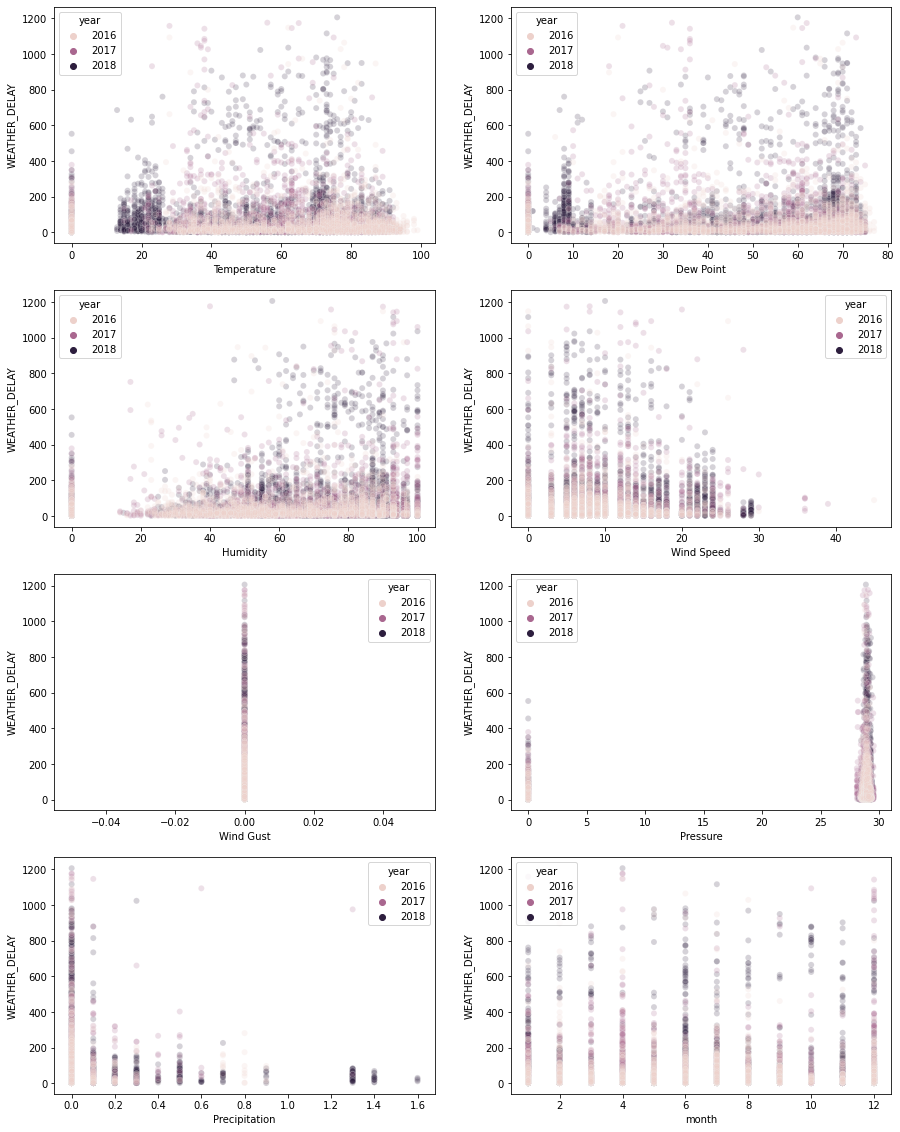

In [8]:
fig,axes = plt.subplots(nrows=4,ncols=2,figsize=(15,20))
#['Temperature','Dew Point','Humidity','Wind Speed','Wind Gust','Pressure','Precipitation','month']
sns.scatterplot(ax=axes[0][0],x=findf['Temperature'],y=findf['WEATHER_DELAY'],alpha=0.2,hue=df['year'])
sns.scatterplot(ax=axes[0][1],x=findf['Dew Point'],y=findf['WEATHER_DELAY'],alpha=0.2,hue=df['year'])
sns.scatterplot(ax=axes[1][0],x=findf['Humidity'],y=findf['WEATHER_DELAY'],alpha=0.2,hue=df['year'])
sns.scatterplot(ax=axes[1][1],x=findf['Wind Speed'],y=findf['WEATHER_DELAY'],alpha=0.2,hue=df['year'])
sns.scatterplot(ax=axes[2][0],x=findf['Wind Gust'],y=findf['WEATHER_DELAY'],alpha=0.2,hue=df['year'])
sns.scatterplot(ax=axes[2][1],x=findf['Pressure'],y=findf['WEATHER_DELAY'],alpha=0.2,hue=df['year'])
sns.scatterplot(ax=axes[3][0],x=findf['Precipitation'],y=findf['WEATHER_DELAY'],alpha=0.2,hue=df['year'])
sns.scatterplot(ax=axes[3][1],x=findf['month'],y=findf['WEATHER_DELAY'],alpha=0.2,hue=df['year'])

# data preprocessing

In [9]:
from sklearn.model_selection import train_test_split
xtrain,xtest,ytrain,ytest = train_test_split(
    findf[['Temperature','Dew Point','Humidity','Wind Speed','Pressure','Precipitation','month']]
    ,findf['WEATHER_DELAY'],test_size=0.2)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(xtrain)
x_train = scaler.transform(xtrain)
x_test = scaler.transform(xtest)

# models

In [20]:
from mlxtend.regressor import StackingCVRegressor
from xgboost import XGBRegressor
from sklearn.mixture import GaussianMixture
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRFRegressor
from sklearn.ensemble import RandomForestRegressor

## the final function

In [26]:
import joblib
import time 

In [25]:
def save_model(model,modelstr):
    to_save = dict(model=model,metadata={})
    model_path = '/home/shaury/Desktop/pvsc/alibaba/'+modelstr+'.joblib'
    with open(model_path, 'wb') as fo:
        joblib.dump(to_save, fo)

In [27]:
def main_model_function(x_train,ytrain,x_test,ytest):
    start = time.time()
    print(start)
    #gaussian mixture model
    err,I = 1000,0
    for i in range(1,40):
        gbmodel = GaussianMixture(n_components=i)
        gbmodel.fit(x_train,ytrain)
        if(err>mean_absolute_error(gbmodel.predict(x_test),ytest)):
            err = mean_absolute_error(gbmodel.predict(x_test),ytest)
            I = i
    gbmodel = GaussianMixture(n_components=I)
    #gbmodel.fit(x_train,ytrain)
    #save_model(gbmodel,"gbmodel")
    #gbpred = gbmodel.predict(x_test)
    
    # lasso model
    alphas = 10**np.arange(-7,0,0.1)
    params = {"alpha":alphas}
    lassocv = GridSearchCV(Lasso(max_iter=1e7),param_grid=params,verbose = 5)
    lassocv.fit(x_train,ytrain)
    lassomodel = Lasso(alpha = lassocv.best_params_['alpha'],max_iter=1e7)
    #lassomodel.fit(x_train,ytrain)
    #save_model(lassomodel,"lassomodel")
    #laspred = lassomodel.predict(x_test)
    
    # xgb random forest regression
    xgrmodel = XGBRFRegressor(gamma=10)
    #xgrmodel.fit(x_train,ytrain)
    #xgrpred = xgrmodel.predict(x_test)
    #save_model(xgrmodel,"xgrmodel")
    
    #random forest regressor
    rfc = RandomForestRegressor()
    #rfc.fit(x_train,ytrain)
    #rfcpred = rfc.predict(x_test)
    #save_model(rfc,"rfcmodel")
    
    #xgb regressor
    lrate = 10**(np.arange(-3,0.2,0.01))
    cvxg = GridSearchCV(XGBRegressor(n_estimators=150),param_grid={"learning_rate":lrate},verbose=5).fit(x_train,ytrain)
    xgbmodel = XGBRegressor(n_estimators=150,learning_rate=cvxg.best_params_['learning_rate'])
    #xgbmodel.fit(x_train,ytrain)
    #xgbpred = xgbmodel.predict(x_test)
    #save_model(xgbmodel,"xgbmodel")
    
    stack = StackingCVRegressor(regressors=(gbmodel, lassomodel, rfc, xgrmodel, xgbmodel),
                            meta_regressor=xgbmodel, cv=10,
                            use_features_in_secondary=True,
                            store_train_meta_features=True,
                            shuffle=False,
                            random_state=42)
    stack.fit(x_train,ytrain)
    save_model(stack,"model")
    print(start- time.time())
    return stack.predict(x_test)

In [28]:
ypred = main_model_function(x_train,ytrain,x_test,ytest)

1631300572.181704
Fitting 5 folds for each of 70 candidates, totalling 350 fits
[CV 1/5] END .......................alpha=1e-07;, score=0.008 total time=   0.4s
[CV 2/5] END .......................alpha=1e-07;, score=0.006 total time=   0.4s
[CV 3/5] END .......................alpha=1e-07;, score=0.007 total time=   0.4s
[CV 4/5] END .......................alpha=1e-07;, score=0.005 total time=   0.4s
[CV 5/5] END .......................alpha=1e-07;, score=0.004 total time=   0.4s
[CV 1/5] END ......alpha=1.2589254117941662e-07;, score=0.008 total time=   0.4s
[CV 2/5] END ......alpha=1.2589254117941662e-07;, score=0.006 total time=   0.3s
[CV 3/5] END ......alpha=1.2589254117941662e-07;, score=0.007 total time=   0.4s
[CV 4/5] END ......alpha=1.2589254117941662e-07;, score=0.005 total time=   0.4s
[CV 5/5] END ......alpha=1.2589254117941662e-07;, score=0.004 total time=   0.3s
[CV 1/5] END .......alpha=1.584893192461111e-07;, score=0.008 total time=   0.4s
[CV 2/5] END .......alpha=1.5

[CV 2/5] END .......alpha=9.999999999999836e-06;, score=0.006 total time=   0.3s
[CV 3/5] END .......alpha=9.999999999999836e-06;, score=0.007 total time=   0.3s
[CV 4/5] END .......alpha=9.999999999999836e-06;, score=0.005 total time=   0.3s
[CV 5/5] END .......alpha=9.999999999999836e-06;, score=0.004 total time=   0.4s
[CV 1/5] END ......alpha=1.2589254117941456e-05;, score=0.008 total time=   0.3s
[CV 2/5] END ......alpha=1.2589254117941456e-05;, score=0.006 total time=   0.3s
[CV 3/5] END ......alpha=1.2589254117941456e-05;, score=0.007 total time=   0.3s
[CV 4/5] END ......alpha=1.2589254117941456e-05;, score=0.005 total time=   0.3s
[CV 5/5] END ......alpha=1.2589254117941456e-05;, score=0.004 total time=   0.3s
[CV 1/5] END .......alpha=1.584893192461085e-05;, score=0.008 total time=   0.3s
[CV 2/5] END .......alpha=1.584893192461085e-05;, score=0.006 total time=   0.3s
[CV 3/5] END .......alpha=1.584893192461085e-05;, score=0.007 total time=   0.3s
[CV 4/5] END .......alpha=1.

[CV 5/5] END .......alpha=0.0009999999999999673;, score=0.004 total time=   0.2s
[CV 1/5] END ........alpha=0.001258925411794125;, score=0.008 total time=   0.2s
[CV 2/5] END ........alpha=0.001258925411794125;, score=0.006 total time=   0.1s
[CV 3/5] END ........alpha=0.001258925411794125;, score=0.007 total time=   0.2s
[CV 4/5] END ........alpha=0.001258925411794125;, score=0.005 total time=   0.1s
[CV 5/5] END ........alpha=0.001258925411794125;, score=0.004 total time=   0.2s
[CV 1/5] END ........alpha=0.001584893192461059;, score=0.008 total time=   0.2s
[CV 2/5] END ........alpha=0.001584893192461059;, score=0.005 total time=   0.2s
[CV 3/5] END ........alpha=0.001584893192461059;, score=0.007 total time=   0.3s
[CV 4/5] END ........alpha=0.001584893192461059;, score=0.005 total time=   0.2s
[CV 5/5] END ........alpha=0.001584893192461059;, score=0.004 total time=   0.2s
[CV 1/5] END .......alpha=0.0019952623149688095;, score=0.008 total time=   0.3s
[CV 2/5] END .......alpha=0.

[CV 2/5] END .........alpha=0.15848931924610332;, score=0.004 total time=   0.1s
[CV 3/5] END .........alpha=0.15848931924610332;, score=0.007 total time=   0.0s
[CV 4/5] END .........alpha=0.15848931924610332;, score=0.006 total time=   0.0s
[CV 5/5] END .........alpha=0.15848931924610332;, score=0.003 total time=   0.0s
[CV 1/5] END .........alpha=0.19952623149687768;, score=0.008 total time=   0.0s
[CV 2/5] END .........alpha=0.19952623149687768;, score=0.003 total time=   0.1s
[CV 3/5] END .........alpha=0.19952623149687768;, score=0.006 total time=   0.0s
[CV 4/5] END .........alpha=0.19952623149687768;, score=0.006 total time=   0.0s
[CV 5/5] END .........alpha=0.19952623149687768;, score=0.003 total time=   0.0s
[CV 1/5] END .........alpha=0.25118864315094486;, score=0.007 total time=   0.1s
[CV 2/5] END .........alpha=0.25118864315094486;, score=0.003 total time=   0.0s
[CV 3/5] END .........alpha=0.25118864315094486;, score=0.006 total time=   0.0s
[CV 4/5] END .........alpha=

[CV 2/5] END learning_rate=0.0013182567385563993;, score=-0.143 total time=   0.4s
[CV 3/5] END learning_rate=0.0013182567385563993;, score=-0.140 total time=   0.3s
[CV 4/5] END learning_rate=0.0013182567385563993;, score=-0.162 total time=   0.3s
[CV 5/5] END learning_rate=0.0013182567385563993;, score=-0.160 total time=   0.4s
[CV 1/5] END learning_rate=0.001348962882591645;, score=-0.191 total time=   0.3s
[CV 2/5] END learning_rate=0.001348962882591645;, score=-0.141 total time=   0.4s
[CV 3/5] END learning_rate=0.001348962882591645;, score=-0.138 total time=   0.3s
[CV 4/5] END learning_rate=0.001348962882591645;, score=-0.160 total time=   0.3s
[CV 5/5] END learning_rate=0.001348962882591645;, score=-0.158 total time=   0.3s
[CV 1/5] END learning_rate=0.0013803842646028753;, score=-0.189 total time=   0.3s
[CV 2/5] END learning_rate=0.0013803842646028753;, score=-0.139 total time=   0.4s
[CV 3/5] END learning_rate=0.0013803842646028753;, score=-0.137 total time=   0.3s
[CV 4/5] 

[CV 2/5] END learning_rate=0.0020892961308540065;, score=-0.103 total time=   0.4s
[CV 3/5] END learning_rate=0.0020892961308540065;, score=-0.102 total time=   0.3s
[CV 4/5] END learning_rate=0.0020892961308540065;, score=-0.120 total time=   0.3s
[CV 5/5] END learning_rate=0.0020892961308540065;, score=-0.114 total time=   0.3s
[CV 1/5] END learning_rate=0.0021379620895021975;, score=-0.144 total time=   0.3s
[CV 2/5] END learning_rate=0.0021379620895021975;, score=-0.101 total time=   0.4s
[CV 3/5] END learning_rate=0.0021379620895021975;, score=-0.100 total time=   0.3s
[CV 4/5] END learning_rate=0.0021379620895021975;, score=-0.118 total time=   0.3s
[CV 5/5] END learning_rate=0.0021379620895021975;, score=-0.112 total time=   0.3s
[CV 1/5] END learning_rate=0.002187761623949516;, score=-0.141 total time=   0.3s
[CV 2/5] END learning_rate=0.002187761623949516;, score=-0.099 total time=   0.4s
[CV 3/5] END learning_rate=0.002187761623949516;, score=-0.097 total time=   0.3s
[CV 4/5

[CV 2/5] END learning_rate=0.0033113112148258263;, score=-0.057 total time=   0.4s
[CV 3/5] END learning_rate=0.0033113112148258263;, score=-0.054 total time=   0.3s
[CV 4/5] END learning_rate=0.0033113112148258263;, score=-0.071 total time=   0.3s
[CV 5/5] END learning_rate=0.0033113112148258263;, score=-0.059 total time=   0.3s
[CV 1/5] END learning_rate=0.003388441561391937;, score=-0.091 total time=   0.3s
[CV 2/5] END learning_rate=0.003388441561391937;, score=-0.055 total time=   0.3s
[CV 3/5] END learning_rate=0.003388441561391937;, score=-0.051 total time=   0.3s
[CV 4/5] END learning_rate=0.003388441561391937;, score=-0.069 total time=   0.4s
[CV 5/5] END learning_rate=0.003388441561391937;, score=-0.056 total time=   0.4s
[CV 1/5] END learning_rate=0.0034673685045252243;, score=-0.089 total time=   0.4s
[CV 2/5] END learning_rate=0.0034673685045252243;, score=-0.052 total time=   0.4s
[CV 3/5] END learning_rate=0.0034673685045252243;, score=-0.048 total time=   0.4s
[CV 4/5] 

[CV 2/5] END learning_rate=0.005248074602497541;, score=-0.010 total time=   0.4s
[CV 3/5] END learning_rate=0.005248074602497541;, score=-0.005 total time=   0.3s
[CV 4/5] END learning_rate=0.005248074602497541;, score=-0.020 total time=   0.3s
[CV 5/5] END learning_rate=0.005248074602497541;, score=-0.001 total time=   0.3s
[CV 1/5] END learning_rate=0.005370317963702335;, score=-0.044 total time=   0.3s
[CV 2/5] END learning_rate=0.005370317963702335;, score=-0.008 total time=   0.4s
[CV 3/5] END learning_rate=0.005370317963702335;, score=-0.003 total time=   0.3s
[CV 4/5] END learning_rate=0.005370317963702335;, score=-0.017 total time=   0.3s
[CV 5/5] END learning_rate=0.005370317963702335;, score=0.002 total time=   0.3s
[CV 1/5] END learning_rate=0.005495408738576046;, score=-0.042 total time=   0.3s
[CV 2/5] END learning_rate=0.005495408738576046;, score=-0.005 total time=   0.4s
[CV 3/5] END learning_rate=0.005495408738576046;, score=-0.001 total time=   0.3s
[CV 4/5] END lear

[CV 3/5] END learning_rate=0.008317637711026334;, score=0.037 total time=   0.3s
[CV 4/5] END learning_rate=0.008317637711026334;, score=0.024 total time=   0.3s
[CV 5/5] END learning_rate=0.008317637711026334;, score=0.048 total time=   0.3s
[CV 1/5] END learning_rate=0.008511380382023375;, score=-0.003 total time=   0.3s
[CV 2/5] END learning_rate=0.008511380382023375;, score=0.033 total time=   0.4s
[CV 3/5] END learning_rate=0.008511380382023375;, score=0.036 total time=   0.3s
[CV 4/5] END learning_rate=0.008511380382023375;, score=0.026 total time=   0.3s
[CV 5/5] END learning_rate=0.008511380382023375;, score=0.051 total time=   0.3s
[CV 1/5] END learning_rate=0.008709635899560404;, score=-0.001 total time=   0.3s
[CV 2/5] END learning_rate=0.008709635899560404;, score=0.036 total time=   0.3s
[CV 3/5] END learning_rate=0.008709635899560404;, score=0.041 total time=   0.3s
[CV 4/5] END learning_rate=0.008709635899560404;, score=0.029 total time=   0.3s
[CV 5/5] END learning_rate

[CV 5/5] END learning_rate=0.013182567385563346;, score=0.083 total time=   0.3s
[CV 1/5] END learning_rate=0.013489628825915787;, score=0.016 total time=   0.3s
[CV 2/5] END learning_rate=0.013489628825915787;, score=0.065 total time=   0.3s
[CV 3/5] END learning_rate=0.013489628825915787;, score=0.062 total time=   0.3s
[CV 4/5] END learning_rate=0.013489628825915787;, score=0.056 total time=   0.3s
[CV 5/5] END learning_rate=0.013489628825915787;, score=0.084 total time=   0.3s
[CV 1/5] END learning_rate=0.013803842646028077;, score=0.019 total time=   0.3s
[CV 2/5] END learning_rate=0.013803842646028077;, score=0.067 total time=   0.4s
[CV 3/5] END learning_rate=0.013803842646028077;, score=0.059 total time=   0.3s
[CV 4/5] END learning_rate=0.013803842646028077;, score=0.057 total time=   0.3s
[CV 5/5] END learning_rate=0.013803842646028077;, score=0.083 total time=   0.3s
[CV 1/5] END learning_rate=0.014125375446226746;, score=0.025 total time=   0.3s
[CV 2/5] END learning_rate=0

[CV 2/5] END learning_rate=0.021379620895020924;, score=0.077 total time=   0.3s
[CV 3/5] END learning_rate=0.021379620895020924;, score=0.072 total time=   0.3s
[CV 4/5] END learning_rate=0.021379620895020924;, score=0.073 total time=   0.3s
[CV 5/5] END learning_rate=0.021379620895020924;, score=0.104 total time=   0.3s
[CV 1/5] END learning_rate=0.021877616239494087;, score=0.018 total time=   0.3s
[CV 2/5] END learning_rate=0.021877616239494087;, score=0.085 total time=   0.3s
[CV 3/5] END learning_rate=0.021877616239494087;, score=0.066 total time=   0.3s
[CV 4/5] END learning_rate=0.021877616239494087;, score=0.071 total time=   0.3s
[CV 5/5] END learning_rate=0.021877616239494087;, score=0.099 total time=   0.3s
[CV 1/5] END learning_rate=0.022387211385681914;, score=0.028 total time=   0.3s
[CV 2/5] END learning_rate=0.022387211385681914;, score=0.080 total time=   0.3s
[CV 3/5] END learning_rate=0.022387211385681914;, score=0.065 total time=   0.3s
[CV 4/5] END learning_rate=0

[CV 4/5] END .learning_rate=0.03388441561391771;, score=0.072 total time=   0.3s
[CV 5/5] END .learning_rate=0.03388441561391771;, score=0.115 total time=   0.3s
[CV 1/5] END .learning_rate=0.03467368504525054;, score=0.017 total time=   0.3s
[CV 2/5] END .learning_rate=0.03467368504525054;, score=0.099 total time=   0.3s
[CV 3/5] END .learning_rate=0.03467368504525054;, score=0.070 total time=   0.3s
[CV 4/5] END .learning_rate=0.03467368504525054;, score=0.077 total time=   0.3s
[CV 5/5] END .learning_rate=0.03467368504525054;, score=0.120 total time=   0.3s
[CV 1/5] END learning_rate=0.035481338923354845;, score=0.013 total time=   0.3s
[CV 2/5] END learning_rate=0.035481338923354845;, score=0.096 total time=   0.3s
[CV 3/5] END learning_rate=0.035481338923354845;, score=0.078 total time=   0.3s
[CV 4/5] END learning_rate=0.035481338923354845;, score=0.077 total time=   0.3s
[CV 5/5] END learning_rate=0.035481338923354845;, score=0.130 total time=   0.3s
[CV 1/5] END learning_rate=0

[CV 1/5] END learning_rate=0.054954087385757765;, score=0.005 total time=   0.3s
[CV 2/5] END learning_rate=0.054954087385757765;, score=0.110 total time=   0.3s
[CV 3/5] END learning_rate=0.054954087385757765;, score=0.079 total time=   0.3s
[CV 4/5] END learning_rate=0.054954087385757765;, score=0.077 total time=   0.3s
[CV 5/5] END learning_rate=0.054954087385757765;, score=0.150 total time=   0.3s
[CV 1/5] END learning_rate=0.056234132519030075;, score=0.001 total time=   0.3s
[CV 2/5] END learning_rate=0.056234132519030075;, score=0.095 total time=   0.3s
[CV 3/5] END learning_rate=0.056234132519030075;, score=0.077 total time=   0.3s
[CV 4/5] END learning_rate=0.056234132519030075;, score=0.072 total time=   0.3s
[CV 5/5] END learning_rate=0.056234132519030075;, score=0.145 total time=   0.3s
[CV 1/5] END learning_rate=0.05754399373371072;, score=-0.001 total time=   0.3s
[CV 2/5] END .learning_rate=0.05754399373371072;, score=0.100 total time=   0.3s
[CV 3/5] END .learning_rate=

[CV 3/5] END .learning_rate=0.08709635899559977;, score=0.075 total time=   0.3s
[CV 4/5] END .learning_rate=0.08709635899559977;, score=0.082 total time=   0.3s
[CV 5/5] END .learning_rate=0.08709635899559977;, score=0.179 total time=   0.3s
[CV 1/5] END .learning_rate=0.08912509381336602;, score=0.000 total time=   0.3s
[CV 2/5] END .learning_rate=0.08912509381336602;, score=0.128 total time=   0.3s
[CV 3/5] END .learning_rate=0.08912509381336602;, score=0.071 total time=   0.3s
[CV 4/5] END .learning_rate=0.08912509381336602;, score=0.069 total time=   0.3s
[CV 5/5] END .learning_rate=0.08912509381336602;, score=0.191 total time=   0.3s
[CV 1/5] END .learning_rate=0.0912010839355822;, score=-0.007 total time=   0.3s
[CV 2/5] END ..learning_rate=0.0912010839355822;, score=0.103 total time=   0.3s
[CV 3/5] END ..learning_rate=0.0912010839355822;, score=0.073 total time=   0.3s
[CV 4/5] END ..learning_rate=0.0912010839355822;, score=0.073 total time=   0.3s
[CV 5/5] END ..learning_rate

[CV 5/5] END .learning_rate=0.13803842646027398;, score=0.200 total time=   0.3s
[CV 1/5] END learning_rate=0.14125375446226052;, score=-0.027 total time=   0.3s
[CV 2/5] END .learning_rate=0.14125375446226052;, score=0.097 total time=   0.3s
[CV 3/5] END .learning_rate=0.14125375446226052;, score=0.052 total time=   0.3s
[CV 4/5] END .learning_rate=0.14125375446226052;, score=0.050 total time=   0.3s
[CV 5/5] END .learning_rate=0.14125375446226052;, score=0.188 total time=   0.3s
[CV 1/5] END learning_rate=0.14454397707457742;, score=-0.020 total time=   0.3s
[CV 2/5] END .learning_rate=0.14454397707457742;, score=0.092 total time=   0.3s
[CV 3/5] END .learning_rate=0.14454397707457742;, score=0.049 total time=   0.3s
[CV 4/5] END .learning_rate=0.14454397707457742;, score=0.036 total time=   0.3s
[CV 5/5] END .learning_rate=0.14454397707457742;, score=0.211 total time=   0.3s
[CV 1/5] END ..learning_rate=0.147910838816805;, score=-0.023 total time=   0.3s
[CV 2/5] END ...learning_rat

[CV 2/5] END .learning_rate=0.22387211385680814;, score=0.111 total time=   0.3s
[CV 3/5] END .learning_rate=0.22387211385680814;, score=0.027 total time=   0.3s
[CV 4/5] END .learning_rate=0.22387211385680814;, score=0.008 total time=   0.3s
[CV 5/5] END .learning_rate=0.22387211385680814;, score=0.197 total time=   0.3s
[CV 1/5] END learning_rate=0.22908676527675076;, score=-0.051 total time=   0.3s
[CV 2/5] END .learning_rate=0.22908676527675076;, score=0.093 total time=   0.3s
[CV 3/5] END .learning_rate=0.22908676527675076;, score=0.034 total time=   0.3s
[CV 4/5] END learning_rate=0.22908676527675076;, score=-0.030 total time=   0.3s
[CV 5/5] END .learning_rate=0.22908676527675076;, score=0.201 total time=   0.3s
[CV 1/5] END learning_rate=0.23442288153196494;, score=-0.067 total time=   0.3s
[CV 2/5] END .learning_rate=0.23442288153196494;, score=0.114 total time=   0.3s
[CV 3/5] END .learning_rate=0.23442288153196494;, score=0.013 total time=   0.3s
[CV 4/5] END learning_rate=0

[CV 4/5] END learning_rate=0.35481338923353106;, score=-0.101 total time=   0.3s
[CV 5/5] END .learning_rate=0.35481338923353106;, score=0.160 total time=   0.3s
[CV 1/5] END .learning_rate=0.3630780547700557;, score=-0.143 total time=   0.3s
[CV 2/5] END ..learning_rate=0.3630780547700557;, score=0.110 total time=   0.3s
[CV 3/5] END .learning_rate=0.3630780547700557;, score=-0.019 total time=   0.3s
[CV 4/5] END .learning_rate=0.3630780547700557;, score=-0.097 total time=   0.3s
[CV 5/5] END ..learning_rate=0.3630780547700557;, score=0.156 total time=   0.3s
[CV 1/5] END learning_rate=0.37153522909712566;, score=-0.124 total time=   0.3s
[CV 2/5] END .learning_rate=0.37153522909712566;, score=0.107 total time=   0.3s
[CV 3/5] END .learning_rate=0.37153522909712566;, score=0.011 total time=   0.3s
[CV 4/5] END learning_rate=0.37153522909712566;, score=-0.095 total time=   0.3s
[CV 5/5] END .learning_rate=0.37153522909712566;, score=0.191 total time=   0.3s
[CV 1/5] END .learning_rate=

[CV 1/5] END ..learning_rate=0.575439937337079;, score=-0.214 total time=   0.4s
[CV 2/5] END ..learning_rate=0.575439937337079;, score=-0.003 total time=   0.4s
[CV 3/5] END ..learning_rate=0.575439937337079;, score=-0.026 total time=   0.4s
[CV 4/5] END ..learning_rate=0.575439937337079;, score=-0.146 total time=   0.4s
[CV 5/5] END ...learning_rate=0.575439937337079;, score=0.113 total time=   0.5s
[CV 1/5] END .learning_rate=0.5888436553555089;, score=-0.233 total time=   0.5s
[CV 2/5] END ..learning_rate=0.5888436553555089;, score=0.043 total time=   0.4s
[CV 3/5] END .learning_rate=0.5888436553555089;, score=-0.043 total time=   0.3s
[CV 4/5] END .learning_rate=0.5888436553555089;, score=-0.166 total time=   0.4s
[CV 5/5] END ..learning_rate=0.5888436553555089;, score=0.129 total time=   0.3s
[CV 1/5] END .learning_rate=0.6025595860742755;, score=-0.236 total time=   0.4s
[CV 2/5] END ..learning_rate=0.6025595860742755;, score=0.044 total time=   0.4s
[CV 3/5] END .learning_rate=

[CV 3/5] END .learning_rate=0.9120108393557772;, score=-0.121 total time=   0.4s
[CV 4/5] END .learning_rate=0.9120108393557772;, score=-0.260 total time=   0.4s
[CV 5/5] END ..learning_rate=0.9120108393557772;, score=0.069 total time=   0.4s
[CV 1/5] END ..learning_rate=0.933254300796855;, score=-0.416 total time=   0.4s
[CV 2/5] END ..learning_rate=0.933254300796855;, score=-0.022 total time=   0.4s
[CV 3/5] END ..learning_rate=0.933254300796855;, score=-0.092 total time=   0.4s
[CV 4/5] END ..learning_rate=0.933254300796855;, score=-0.211 total time=   0.4s
[CV 5/5] END ...learning_rate=0.933254300796855;, score=0.075 total time=   0.4s
[CV 1/5] END .learning_rate=0.9549925860212962;, score=-0.366 total time=   0.4s
[CV 2/5] END .learning_rate=0.9549925860212962;, score=-0.093 total time=   0.4s
[CV 3/5] END .learning_rate=0.9549925860212962;, score=-0.131 total time=   0.4s
[CV 4/5] END .learning_rate=0.9549925860212962;, score=-0.230 total time=   0.4s
[CV 5/5] END ..learning_rate

[CV 5/5] END .learning_rate=1.4454397707457034;, score=-0.101 total time=   0.4s
[CV 1/5] END .learning_rate=1.4791083881679772;, score=-0.608 total time=   0.4s
[CV 2/5] END .learning_rate=1.4791083881679772;, score=-0.253 total time=   0.4s
[CV 3/5] END .learning_rate=1.4791083881679772;, score=-0.282 total time=   0.4s
[CV 4/5] END .learning_rate=1.4791083881679772;, score=-0.400 total time=   0.4s
[CV 5/5] END .learning_rate=1.4791083881679772;, score=-0.111 total time=   0.4s
[CV 1/5] END ..learning_rate=1.513561248435972;, score=-0.693 total time=   0.4s
[CV 2/5] END ..learning_rate=1.513561248435972;, score=-0.301 total time=   0.4s
[CV 3/5] END ..learning_rate=1.513561248435972;, score=-0.370 total time=   0.4s
[CV 4/5] END ..learning_rate=1.513561248435972;, score=-0.558 total time=   0.4s
[CV 5/5] END ..learning_rate=1.513561248435972;, score=-0.101 total time=   0.4s
[CV 1/5] END .learning_rate=1.5488166189122388;, score=-0.590 total time=   0.4s
[CV 2/5] END .learning_rate=